In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import subprocess
import astroML
import sklearn
import os
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import kde


from sklearn import preprocessing
%matplotlib inline

### Process
#### 1. Reduce the dimensionality in the data
Principal Component Anaylsis 
#### 2. Using several rows as a training set
0:175,000 rows
#### 3. Testing with other rows
176,000 : 300,000 rows
#### 4. Compare predicted redshift distribution vs. actual data

#### Getting Data

In [12]:
cols=['z','dered_u','dered_g','dered_r','dered_i','dered_z','dered_color_ug','dered_color_gr','dered_color_ri','dered_color_iz','dered_frac_uz','C']
data = pd.read_csv("/Users/linaflorez/Downloads/SDSS_DR12_awe2_0.csv", usecols = cols)
df_ztrim = data[data.z <=0.4]
dat = df_ztrim.drop(['z'], axis=1)
dat = dat.to_numpy()
print("Shape of the dataframe:", np.shape(dat))
df_ztrim

Shape of the dataframe: (589058, 11)


,z,dered_u,dered_g,dered_r,dered_i,dered_z,dered_color_ug,dered_color_gr,dered_color_ri,dered_color_iz,dered_frac_uz,C
0,0.106029,20.07695,18.21239,17.23913,16.82238,16.49874,1.864559,0.973261,0.416756,0.323633,1.216878,2.958234
1,0.072062,18.76690,17.66344,17.22466,16.92888,16.84306,1.103458,0.438782,0.295778,0.085827,1.114222,1.990836
2,0.172250,19.78869,18.18713,17.25847,16.89089,16.60906,1.601561,0.928652,0.367588,0.281828,1.191439,2.673254
3,0.070081,18.42462,16.54012,15.65375,15.23006,14.89166,1.884495,0.886367,0.423692,0.338399,1.237244,3.322546
4,0.121415,19.67483,18.07697,17.21868,16.78680,16.42058,1.597860,0.858295,0.431875,0.366219,1.198181,2.325654
...,...,...,...,...,...,...,...,...,...,...,...,...
592325,0.141583,19.52045,18.18918,17.39393,16.92188,16.61678,1.331274,0.795250,0.472046,0.305101,1.174743,3.091621
592326,0.086905,19.44842,17.70323,16.88538,16.49578,16.20966,1.745186,0.817852,0.389603,0.286120,1.199804,2.978100
592327,0.084092,19.76636,18.21106,17.38570,16.94000,16.63187,1.555298,0.825361,0.445703,0.308124,1.188463,2.429317
592328,0.139988,19.48265,18.08657,17.29824,16.84090,16.57250,1.396088,0.788324,0.457344,0.268402,1.175602,2.709363


#### Using PCA

In [54]:
# Compute PCA
def compute_PCA(input_data, n_components):
    
    # we're setting the mean as the first component
    mean = input_data.mean(0)
    pca = PCA(n_components)
    
    pca.fit(input_data)
    
    # the PCA eigen"spectra" are:
    pca_comp = np.vstack([mean, pca.components_])
    
    # and the explained variance is:
    evals = pca.explained_variance_ratio_
    evals_cs = evals.cumsum()

    #Checking to see if dimensionality was reduced
    pca_transformed = pca.transform(dat)
    
    return pca_transformed, evals, evals_cs, pca.components_, pca.mean_



#### K-Means

In [79]:
def K_Means_Regressor(og_data, number_of_pc, n_neighbors, test_rows, actualdata_rows):
    #Computing PCA
    pca_data, e, e_cs, components, pca_mean = compute_PCA(og_data, number_of_pc)
    
    #K-Means Nearest Neighbors
    neigh = KNeighborsRegressor(n_neighbors)
    neigh.fit(pca_data[0:test_rows], df_ztrim.z.iloc[0:test_rows])
    predicted_redshift = neigh.predict(pca_data[test_rows:actualdata_rows])
    
    return predicted_redshift

#### Testing

In [45]:
results = []

#iterating through num principal components and neighbors
for i in range(2,10):
    for j in range(2,10):
        num_components, neighbors = i, j
        y_pred = K_Means_Regressor(dat, num_components, neighbors, 175000, 300000)

        y_val_examine = df_ztrim.z.iloc[175000:300000]

        x=y_val_examine
        # y=np.sum(range_z*y_pred,1) #for categorical
        y=y_pred #for regression

        #summary stats
        residuals = (x-y)/(1+x)
        bias = np.mean(residuals)
        MAD = 1.4826*np.median(abs(residuals - np.median(residuals)))
        outlier_fraction_eta = len(residuals[residuals > 5*MAD])/len(residuals)
        eta_LSST = len(residuals[residuals > 3*MAD*(1+residuals)])/len(residuals)
        RMS = np.sqrt(np.mean(np.square(residuals)))
        
        results.append([i, j, round(MAD,4),round(bias,4), round(outlier_fraction_eta,4),\
                        round(RMS,4), round(eta_LSST,4)])

In [111]:
stats_df = pd.DataFrame()
list_vals = np.asarray(results)
stats_df["PC"] = np.array(list_vals[:,0], dtype = "int")
stats_df["Neighbors"] = np.array(list_vals[:,1], dtype = "int")
stats_df["MAD"] = list_vals[:,2]
stats_df["bias"] = list_vals[:,3]
stats_df["outlier"] = list_vals[:,4]
stats_df["RMS"] = list_vals[:,5]
stats_df["eta"] = list_vals[:,6]

In [114]:
stats_df[stats_df.MAD == stats_df.MAD.min()]

,PC,Neighbors,MAD,bias,outlier,RMS,eta
39,6,9,0.0168,-0.0006,0.0018,0.0215,0.0127
47,7,9,0.0168,-0.0006,0.0017,0.0215,0.0126
55,8,9,0.0168,-0.0006,0.0017,0.0215,0.0126
63,9,9,0.0168,-0.0006,0.0017,0.0215,0.0126


In [77]:
pc_num, neighbor_num = 7, 9

Data Reduced:
Original data: (589058, 11)
PCA transformed data: (589058, 7) 
 



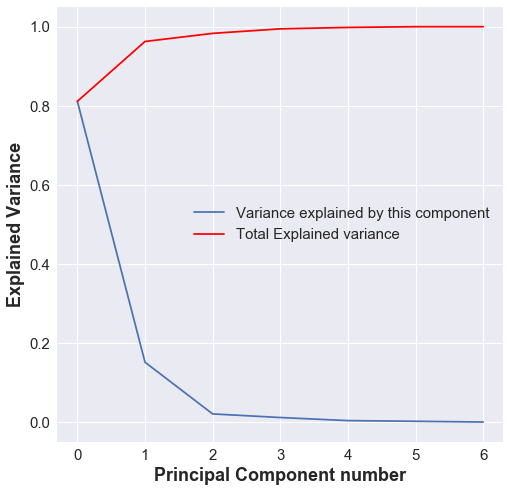

In [115]:
pca_data, e, e_cs, components, pca_mean_ = compute_PCA(dat, pc_num)

print("Data Reduced:")
print('Original data:', dat.shape)
print('PCA transformed data:',pca_data.shape, "\n \n")

plt.figure(figsize = (8,8))
plt.plot(e, label='Variance explained by this component')
plt.plot(e_cs, 'r', label='Total Explained variance')
plt.xlabel('Principal Component number', weight = "bold", size = 18)
plt.ylabel('Explained Variance', weight = "bold", size = 18)
ax = plt.gca()
ax.set_xticks(range(pc_num));
plt.legend(loc = "best", prop = {"size":15})
plt.tick_params("both", labelsize = 15)
plt.savefig("/Users/linaflorez/Desktop/Variance.png")

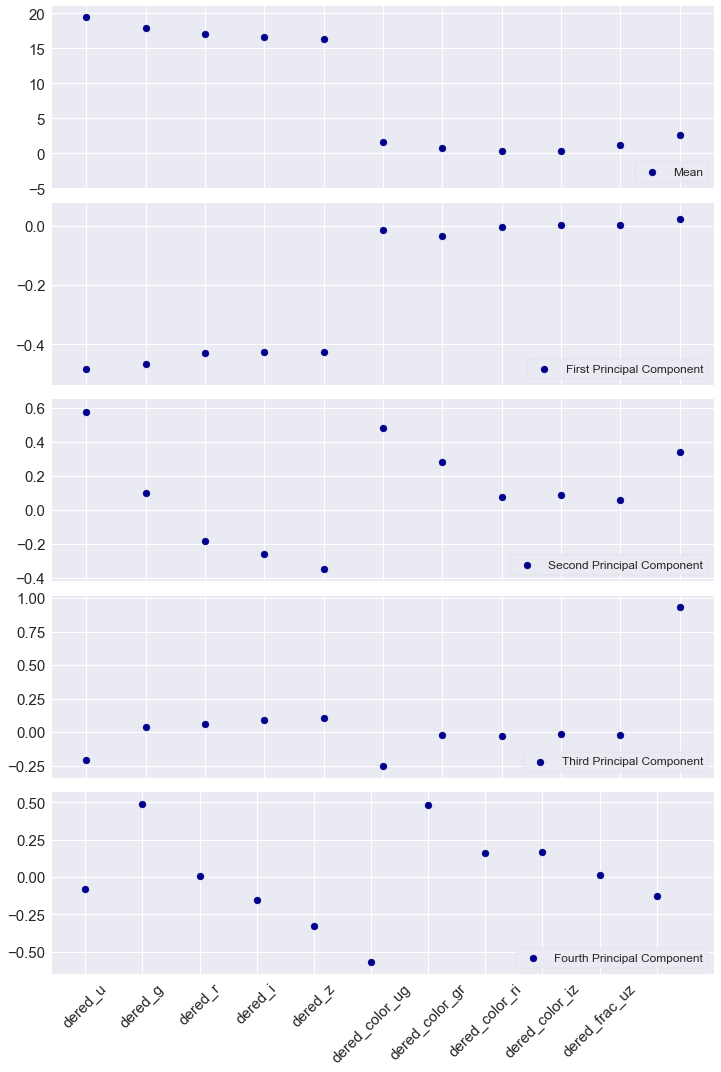

In [91]:
fig, ((ax1), (ax2), (ax3), (ax4), (ax5)) = plt.subplots(5,1, figsize = (10,15), sharex = True)

x_vals = np.arange(0, dat.shape[1], 1)

ax1.scatter(x_vals, pca_mean_, color = "darkblue", label = "Mean")
ax1.set_ylim(-5, 21)
ax1.legend(loc = "lower right", prop = {"size":12}, frameon = True)
ax1.tick_params("both", labelsize = 15)

ax2.scatter(x_vals, components[0], color = "darkblue", label = "First Principal Component")
ax2.legend(loc = "lower right", prop = {"size":12}, frameon = True)
ax2.tick_params("both", labelsize = 15)

ax3.scatter(x_vals, components[1], color = "darkblue", label = "Second Principal Component")
ax3.legend(loc = "lower right", prop = {"size":12}, frameon = True)
ax3.tick_params("both", labelsize = 15)

ax4.scatter(x_vals, components[2], color = "darkblue", label = "Third Principal Component")
ax4.legend(loc = "lower right", prop = {"size":12}, frameon = True)
ax4.tick_params("both", labelsize = 15)

ax5.scatter(x_vals, components[3], color = "darkblue", label = "Fourth Principal Component")
ax5.set_xticks(range(12))
ax5.set_xticklabels(df_ztrim.columns[1:-1].to_list(), rotation = 45, size = 12)
ax5.legend(loc = "lower right", prop = {"size":12}, frameon = True)
ax5.tick_params("both", labelsize = 15)

plt.tight_layout()

#### Comparing Distributions

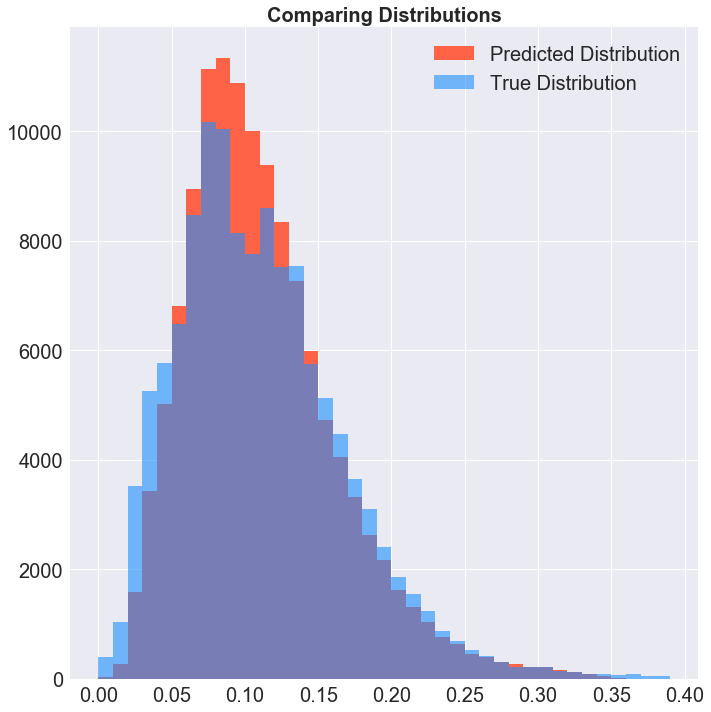

In [87]:
y_pred = K_Means_Regressor(dat, pc_num, neighbor_num, 175000, 300000)

plt.figure(figsize = (10,10))
plt.title('Comparing Distributions', weight = "bold", size = 20)
bins_ = np.arange(0,df_ztrim.z.max(),0.01)
plt.hist(y_pred, bins = bins_, color = "tomato", label = "Predicted Distribution")
plt.hist(df_ztrim.z.loc[175000:300000], bins = bins_, color = "dodgerblue", alpha = 0.6, label = "True Distribution")
plt.legend(loc = "best", prop = {"size":20})
plt.tick_params("both", labelsize = 20)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ComparingDistributions.png")

Number of Principal Components: 7
Number of nearest neighbors: 9
MAD: 0.0168
bias: -0.0006
outlier_fraction_eta pasquet:  0.0017
RMS:  0.0215
outlier fraction LSST:  0.0126


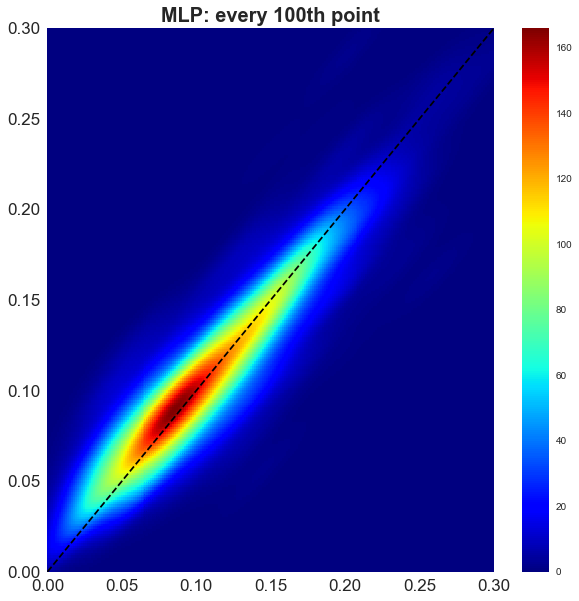

In [89]:
y_pred = K_Means_Regressor(dat, pc_num, neighbor_num, 175000, 300000)

y_val_examine = df_ztrim.z.iloc[175000:300000]

x=y_val_examine
# y=np.sum(range_z*y_pred,1) #for categorical
y=y_pred #for regression

#summary stats
residuals = (x-y)/(1+x)
bias = np.mean(residuals)
MAD = 1.4826*np.median(abs(residuals - np.median(residuals)))
outlier_fraction_eta = len(residuals[residuals > 5*MAD])/len(residuals)
eta_LSST = len(residuals[residuals > 3*MAD*(1+residuals)])/len(residuals)
RMS = np.sqrt(np.mean(np.square(residuals)))
#print('CRPS: ',round(CRPS_estimator,4))
print("Number of Principal Components:", pc_num)
print('Number of nearest neighbors:', neighbor_num)
print('MAD:',round(MAD,4))
print('bias:',round(bias,4))
print('outlier_fraction_eta pasquet: ',round(outlier_fraction_eta,4))
print('RMS: ',round(RMS,4))
print('outlier fraction LSST: ',round(eta_LSST,4))

#KDE plot
nbins=300
x_100=x[::100]
y_100=y[::100]

k = kde.gaussian_kde([x_100,y_100])
xi, yi = np.mgrid[0:0.4:nbins*1j, 0:0.4:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.figure(figsize = (10,10))
plt.title('MLP: every 100th point', weight = "bold", size = 20)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='jet')
plt.plot([0,1],[0,1],'k--')
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.colorbar()
plt.tick_params("both", labelsize = 17)
plt.savefig("/Users/linaflorez/Desktop/MLP.png")